In [12]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from jaxgym.run import propagate
import jaxgym.components as comp
from jaxgym.stemoverfocus import project_frame_backward, project_frame_forward, run_model_for_rays_and_slopes
from optax import adam, apply_updates
from jaxgym.ray import Ray
import os
import tqdm.auto as tqdm
import json

jax.config.update('jax_platform_name', 'cpu')

from libertem_ui.display.display_base import Curve
import panel as pn
from bokeh.plotting import figure



In [ ]:
def run_model_for_jacobians(ray, model):

    model_ray_jacobians = []

    # Get all jacobians from one component to another
    for i in range(1, len(model)):
        distance = (model[i].z - ray.z).squeeze()

        '''
        This block of code here is akin to calling value_and_grad on a function in jax
        to get it's gradients, except we are doing instead value_and_jacobian to get the ray transfer matrix. 
        We need to step the ray that represents the optical axis through the system, and we also need it's jacobian
        (ABCD transfer matrix) through each propagation and step. 
        First we call the jacobian on the propagation step to get the transfer matrix. This
        does not actually propagate the ray, it only gets its derivatives, so to get the rays "value" from the 
        propagation function, we then call the propagate step on the ray without calling the jacobian. 
        Thus once the same function has been called with and without the jacobian, we have calcualted the "value_and_jacobian" of the ray.
        This process is repeated for the step function of the component to get the value and jacobian of the ray. 
        '''
        # Get the jacobian of the ray propagation
        # from the previous component to the current component
        propagate_jacobian = jax.jacobian(propagate, argnums=1)(distance, ray)
        model_ray_jacobians.append(propagate_jacobian)

        # Propagate the ray
        ray = propagate(distance, ray)

        # Get the jacobian of the step function of the current component
        component_jacobian = jax.jacobian(model[i].step)(ray)
        model_ray_jacobians.append(component_jacobian)

        #Step the ray
        ray = model[i].step(ray)

    # Edit the jacobian matrices to include shifts calculated 
    # from the optical path length derivative - not the best solution for now but it works.
    ABCDs = [] #ABCD matrices at each component

    for ray_jacobian in model_ray_jacobians:
        shift_vector = ray_jacobian.pathlength.matrix # This is the shift vector for each ray, dopl_out/dr_in
        ABCD = ray_jacobian.matrix.matrix # This is the ABCD matrix for each ray, dr_out/dr_in
        ABCD = ABCD.at[:, -1].set(shift_vector[0, :])
        ABCD = ABCD.at[-1, -1].set(1.0) # Add the final one to bottom right corner of the matrix.
        ABCDs.append(ABCD)

    return jnp.array(ABCDs)


def analytically_evaluate_tilts(
    det_coords, scan_pos, semi_conv, transformation_matrix
):
    """
    Given a set of detector pixel coordinates, a semi-convergence angle from a source, and a transformation matrix,
    find a the input slopes which will hit the detector pixels. Also mask out the input slopes which are greater 
    than the semi-convergence angle.
    """
    scan_pos_y, scan_pos_x = scan_pos

    A_xx, A_xy, B_xx, B_xy = transformation_matrix[0, :4]  # Select first row excluding the last column
    A_yx, A_yy, B_yx, B_yy = transformation_matrix[1, :4]  # Select second row excluding the last column

    delta_x, delta_y = transformation_matrix[0, 4], transformation_matrix[1, 4]

    y_out, x_out = det_coords[:, 0], det_coords[:, 1]

    denom = B_xx * B_yy - B_xy * B_yx
    theta_x_in = (
        -A_xx * B_yy * scan_pos_x
        - A_xy * B_yy * scan_pos_y
        + A_yx * B_xy * scan_pos_x
        + A_yy * B_xy * scan_pos_y
        + B_xy * delta_y
        - B_xy * y_out
        - B_yy * delta_x
        + B_yy * x_out
    ) / denom

    theta_y_in = (
        A_xx * B_yx * scan_pos_x
        + A_xy * B_yx * scan_pos_y
        - A_yx * B_xx * scan_pos_x
        - A_yy * B_xx * scan_pos_y
        - B_xx * delta_y
        + B_xx * y_out
        + B_yx * delta_x
        - B_yx * x_out
    ) / denom

    F = (theta_x_in**2 + theta_y_in**2) - semi_conv**2

    semi_conv_mask = F <= 0
    input_slopes = np.stack([theta_x_in, theta_y_in])

    return input_slopes, semi_conv_mask

def loss(det_coords, tilts, inv_matrix, scan_pos_yx):
    n_rays = det_coords.shape[0]

    det_coords_y, det_coords_x = det_coords[:, 0], det_coords[:, 1]
    
    rays_det_matrix = jnp.array([det_coords_x, 
                                 det_coords_y,
                                 tilts[:, 0],
                                 tilts[:, 1],
                                 jnp.ones(n_rays)])
    
    rays_pt_source = jnp.matmul(inv_matrix, rays_det_matrix).T

    rays_pt_source_y = rays_pt_source[:, 1]
    rays_pt_source_x = rays_pt_source[:, 0]
    
    start_position = jnp.array([rays_pt_source_y, rays_pt_source_x])   

    error = jnp.linalg.norm(start_position - scan_pos_yx) 

    return error


In [14]:
fourdstem_array = np.load('fourdstem_array.npy')
params_dict = json.load(open('params.json'))

semi_conv = params_dict['semi_conv']
defocus = params_dict['defocus']
camera_length = params_dict['camera_length']
scan_shape = params_dict['scan_shape']
det_shape = params_dict['det_shape']
scan_step_yx = params_dict['scan_step_yx']
det_px_size = params_dict['det_px_size']
scan_rotation = params_dict['scan_rotation']
descan_error = params_dict['descan_error']

In [15]:
#Create ray input z plane
crossover_z = jnp.zeros((1))

PointSource = comp.PointSource(z=crossover_z, semi_conv=semi_conv)
ScanGrid = comp.ScanGrid(z=jnp.array([params_dict['defocus']]), 
                         scan_step_yx=params_dict['scan_step_yx'], 
                         scan_shape_yx=params_dict['scan_shape'], 
                         scan_rotation=params_dict['scan_rotation'])

scan_coords_yx = ScanGrid.coords
scan_y, scan_x = scan_coords_yx[0, 0], scan_coords_yx[0, 1]

Descanner = comp.Descanner(z=jnp.array([params_dict['defocus']]), 
                           descan_error=params_dict['descan_error'], 
                           offset_x=scan_x, 
                           offset_y=scan_y)

Detector = comp.Detector(z=jnp.array([params_dict['camera_length']]), det_shape_yx=params_dict['det_shape'], det_pixel_size_yx=params_dict['det_px_size'])
model = [PointSource, ScanGrid, Descanner, Detector]

In [ ]:
# Prepare input ray position for this scan point.
input_ray_positions = jnp.array([scan_x, scan_y, 0.0, 0.0, 1.0])

ray = Ray(
    z=PointSource.z,
    matrix=input_ray_positions,
    amplitude=jnp.ones(1),
    pathlength=jnp.zeros(1),
    wavelength=jnp.ones(1),
    blocked=jnp.zeros(1, dtype=float)
)

transfer_matrices = run_model_for_jacobians(ray, model)

# Initialise the total_transfer_matrix
# as the last transfer matrix in the list,
# and multiply it with the previous transfer matrices
# in reverse order to get the total transfer matrix
# for the whole model.
total_transfer_matrix = transfer_matrices[-1]
for tm in reversed(transfer_matrices[:-1]):
    total_transfer_matrix = total_transfer_matrix @ tm

detector_to_point_source_matrix = jnp.linalg.inv(total_transfer_matrix)

There are two pathways to finding the tilts that will strike each detector pixel:

1. Propagate rays back from the detector, and minimise the loss of their distance from a perfect point source at the scan position  
2. Analytically solve for the tilts using the ray transfer matrix, because the system is linear. (Remember we can still do this for a non-linear system, it just becomes a root solving problem instead)

In [ ]:
bkfig = figure()
bkplot = (
    Curve
    .new()
    .from_vectors([], [])
    .on(bkfig)
)

bkfig.xaxis.axis_label = "Iteration"
bkfig.yaxis.axis_label = "Loss"

pn.pane.Bokeh(bkfig)

BokehModel(combine_events=True, render_bundle={'docs_json': {'f1628018-d089-4063-b803-ce8776c7b624': {'version…

In [19]:

det_coords = Detector.get_coords()
tilts = jax.random.uniform(jax.random.PRNGKey(0), shape=(det_coords.shape[0], 2), minval=0.0, maxval=0.1)
scan_pos_yx = jnp.array([[scan_y, scan_x]]).T

optimiser = adam(learning_rate=1e-4)
opt_state = optimiser.init(tilts)
n_iterations = 4000

iterations = []
losses = []

for i in tqdm.tqdm(range(n_iterations)):
    loss_value, gradients = jax.value_and_grad(loss, argnums=1)(
        det_coords, tilts, detector_to_point_source, scan_pos_yx
    )

    updates, opt_state = optimiser.update(gradients, opt_state)
    tilts = apply_updates(tilts, updates)
    
    iterations.append(i)
    losses.append(loss_value)

    if loss_value < 1e-5:
        break

  0%|          | 0/4000 [00:00<?, ?it/s]

In [20]:
analytic_input_slopes = analytically_evaluate_tilts(det_coords, scan_pos_yx, semi_conv, total_transfer_matrix)

# Run the model to obtain the ray coordinates at each component in the model
coords = run_model_for_rays_and_slopes(transfer_matrices, analytic_input_slopes, scan_pos_yx)
xs, ys, dxs, dys = coords
analytic_output_slopes = jnp.array([dxs[-1], dys[-1]]).T

loss_value = loss(
    det_coords, analytic_output_slopes, detector_to_point_source, scan_pos_yx
)
print(loss_value)

0.0


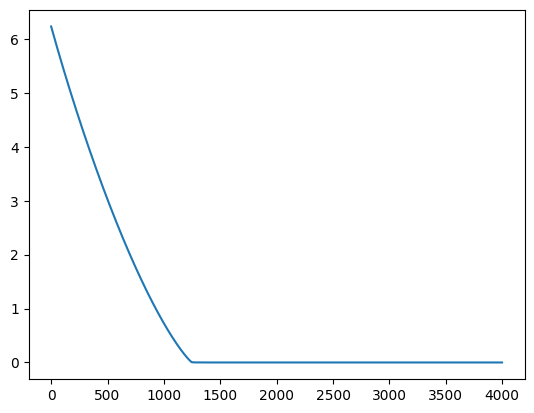

In [21]:
plt.figure()
plt.plot(iterations, losses)



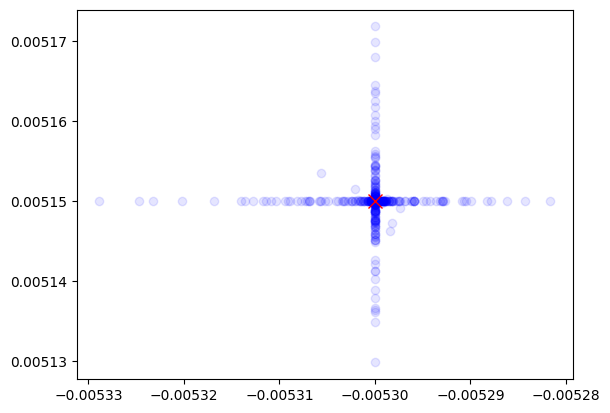

In [22]:
n_rays = det_coords.shape[0]
det_coords_y, det_coords_x = det_coords[:, 0], det_coords[:, 1]

rays_det_matrix = jnp.array([det_coords_x, 
                                det_coords_y,
                                tilts[:, 0],
                                tilts[:, 1],
                                jnp.ones(n_rays)])

rays_pt_source = jnp.matmul(detector_to_point_source, rays_det_matrix).T

rays_pt_source_y = rays_pt_source[:, 1]
rays_pt_source_x = rays_pt_source[:, 0]

plt.figure()
plt.plot(scan_pos_yx[1], scan_pos_yx[0], 'rx', label='Scan Position', markersize=10, zorder=10)
plt.plot(rays_pt_source_x, rays_pt_source_y, 'bo', label='Ray Position', alpha=0.1)